In [2]:
# %%
# --- セル 1: 必要なライブラリのインポート ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from pathlib import Path
from tqdm import tqdm
from typing import List, Dict, Iterable, Tuple, Optional
import mne  # MNE-Pythonを追加

# %%
# --- セル 2: config 変数の定義 ---
# (src.config からのインポートが機能しない場合、ここで直接定義する)
try:
    # VSCodeでの実行を想定し、_init_notebookは削除
    import _init_notebook 
    from src.config import (
        PROCESSED_DIR, TMIN, TMAX, BASELINE, SAMPLING_RATE,
        EEG_CHANNELS_TO_FILTER, EVENT_RANGES, N_JOBS, FREQS
    )
except ImportError:
    print("src.config を読み込めないため、変数を仮設定します。")
    

# %%
# --- セル 3: TFR計算集計関数の定義 (新規) ---

def aggregate_ersp_data(
    processed_dir: Path,
    event_ranges: Dict[str, Tuple[int, int]],
    channels: List[str],
    tmin: float,
    tmax: float,
    baseline_sec: Tuple[float, float],
    sfreq: int,
    freqs: np.ndarray,
    n_jobs: int
) -> Optional[pd.DataFrame]:
    """
    個体ごとのファイルから試行平均TFR(ERSP)を計算し、全個体分を集計する。
    メモリ対策のため、試行平均後のデータのみを保持する。
    """
    if not isinstance(freqs, np.ndarray):
        freqs = np.array(freqs, dtype=float)    
    
    processed_path = Path(processed_dir)
    files = list(processed_path.glob('*.parquet'))
    read_func_name = 'read_parquet'
    
    if not files:
        files = list(processed_path.glob('*.csv'))
        read_func_name = 'read_csv'
        
    if not files:
        print(f"エラー: {processed_dir} にファイルが見つかりません。")
        return None

    print(f"{len(files)} 個のファイルからERSPを集計します...")
    
    all_ersp_data = []
    required_cols = channels + ['Event_ID', 'Stimulus_Type', 'Subject_ID', 'Genotype']
    
    # モルレウェーブレットのサイクル数 (周波数に応じて増やす例)
    n_cycles = freqs / 2.0  # configから読み込んでも良い

    for file_path in tqdm(files, desc="Processing files"):
        try:
            # --- 1. データ読み込み ---
            if read_func_name == 'read_parquet':
                df = pd.read_parquet(file_path, columns=required_cols)
            else:
                df = pd.read_csv(file_path, usecols=required_cols)

            if df.empty:
                continue

            subject_id = df['Subject_ID'].iloc[0]
            genotype = df['Genotype'].iloc[0]

            # --- 2. MNE RawArray オブジェクトの作成 ---
            data = df[channels].values.T  # (n_channels, n_samples)
            info = mne.create_info(ch_names=channels, sfreq=sfreq, ch_types=['eeg'] * len(channels))
            raw = mne.io.RawArray(data, info, verbose=False)

# --- 3. MNE Events の作成 (ロジック修正) ---
            # df['Event_ID'] の値ではなく、df['Stimulus_Type'] の文字列を
            # MNE用の int ID にマッピングする
            
            event_starts = df['Event_ID'].diff().fillna(0)
            event_indices = event_starts[event_starts > 0].index
            
            # イベント発生時点の Stimulus_Type を取得
            stim_types_at_events = df.loc[event_indices, 'Stimulus_Type']
            
            # MNE用の event_id 辞書を config の event_ranges の *キー* から作成
            # 'No_Stimulus' は 0、他は 1, 2, 3... と連番(int)を割り当てる
            mne_event_id_dict = {}
            current_id = 1
            
            # 'No_Stimulus' を優先的に 0 に割り当て (存在する場合)
            if 'No_Stimulus' in event_ranges:
                mne_event_id_dict['No_Stimulus'] = 0

            # 残りのキーに 1 から順にIDを割り当て
            for stim_name in event_ranges.keys():
                if stim_name not in mne_event_id_dict:
                    mne_event_id_dict[stim_name] = current_id
                    current_id += 1
            
            # df['Stimulus_Type'] (文字列) を MNEのID (int) にマッピング
            # 辞書にない Stimulus_Type (例: 'Error'など) は -1 を割り当てて無視する
            event_ids = [mne_event_id_dict.get(stim, -1) for stim in stim_types_at_events]

            # MNEが要求するイベント配列 [サンプル番号, 0, イベントID]
            events = np.array([event_indices, np.zeros_like(event_indices), event_ids]).T.astype(int)
            
            # -1 (無視対象) のイベントを除外
            events = events[events[:, 2] != -1]


            # --- 4. MNE Epochs の作成 ---
            # (mne_event_id_dict は上で作成済み)

            epochs = mne.Epochs(
                raw,
                events=events,
                event_id=mne_event_id_dict, # ★ int を値に持つ辞書を使用
                tmin=tmin,
                tmax=tmax,
                preload=True,
                baseline=None,
                reject=None,
                verbose=False
            )
            
            del df, raw # メモリ解放

            # --- 5. 刺激ごとのTFR計算 (試行平均) ---
            for stim_name in event_ranges.keys():
                try:
                    stim_epochs = epochs[stim_name]
                    if len(stim_epochs) == 0:
                        continue
                        
                    # 試行平均TFR (ERSP) を計算 (メモリ対策のため average=True)
                    tfr = mne.time_frequency.tfr_morlet(
                        stim_epochs,
                        freqs=freqs,
                        n_cycles=n_cycles,
                        use_fft=True,
                        return_itc=False,
                        average=True,  # ★重要: 試行平均する
                        n_jobs=n_jobs,
                        verbose=False
                    )
                    
                    # ベースライン補正 (デシベル変換)
                    # 'logratio' が一般的
                    tfr.apply_baseline(baseline=baseline_sec, mode='logratio', verbose=False)
                    
                    # --- 6. 結果をLong Formatでリストに追加 ---
                    times = tfr.times
                    # チャンネル名を _filtered なしに
                    ch_names_clean = [ch.replace('_filtered', '') for ch in tfr.ch_names]
                    
                    # tfr.data は (n_channels, n_freqs, n_times)
                    for i_ch, ch_name in enumerate(ch_names_clean):
                        for i_freq, freq in enumerate(freqs):
                            for i_time, time in enumerate(times):
                                all_ersp_data.append({
                                    'Subject_ID': subject_id,
                                    'Genotype': genotype,
                                    'Stimulus': stim_name,
                                    'Channel': ch_name,
                                    'Frequency': freq,
                                    'Time': time,
                                    'Power_dB': tfr.data[i_ch, i_freq, i_time]
                                })
                                
                except KeyError:
                    # print(f"警告: {file_path.name} に 刺激 '{stim_name}' のイベントがありません。")
                    continue
            
            del epochs # メモリ解放

        except Exception as e:
            print(f"エラー処理中 {file_path.name}: {e}")

    if not all_ersp_data:
        print("集計データがありません。")
        return None
        
    print("DataFrameに変換中...")
    return pd.DataFrame(all_ersp_data)


Notebook init: PROJECT_ROOT=c:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze


In [6]:
# %%
# --- セル 4: 可視化関数の定義 (TFRヒートマップ版 / スケール(-0.5, 0.5)統一 / 差分) ---

def plot_grouped_ersp(
    ersp_df: pd.DataFrame,
    clim: Tuple[float, float] = (-0.5, 0.5) # ★変更点: スケールをデフォルトで (-0.5, 0.5) に
):
    """
    集計されたERSPデータを使い、Genotypeごとの平均TFRヒートマップと、
    その差分(WT - Het)をプロットする。
    カラースケールは全プロットで統一する。
    """
    if ersp_df is None or ersp_df.empty:
        print("プロットするデータがありません。")
        return

    print("プロットを生成中...")
    
    # チャンネルと刺激の順序を決定
    channels_order = [ch.replace('_filtered', '') for ch in EEG_CHANNELS_TO_FILTER]
    stimuli_order = list(EVENT_RANGES.keys())
    
    # グループ平均を計算
    df_mean_subject = ersp_df.groupby(
        ['Subject_ID', 'Genotype', 'Stimulus', 'Channel', 'Frequency', 'Time']
    )[['Power_dB']].mean().reset_index()
    
    df_mean_group = df_mean_subject.groupby(
        ['Genotype', 'Stimulus', 'Channel', 'Frequency', 'Time']
    )[['Power_dB']].mean().reset_index()

    # ★削除: climの自動調整ロジックを削除 (引数のclimをそのまま使うため)
    
    # N数を計算
    n_counts = ersp_df.groupby(['Genotype', 'Stimulus'])['Subject_ID'].nunique()
    
    #  stimulation ごとに図を作成
    for stim_name in stimuli_order:
        stim_df = df_mean_group[df_mean_group['Stimulus'] == stim_name]
        
        if stim_df.empty:
            print(f"Warning: 刺激 '{stim_name}' のデータが見つかりません。")
            continue
            
        data_wt = stim_df[stim_df['Genotype'] == 'WT']
        data_het = stim_df[stim_df['Genotype'] == 'Het']
        
        n_wt = n_counts.get(('WT', stim_name), 0)
        n_het = n_counts.get(('Het', stim_name), 0)

        fig, axes = plt.subplots(
            nrows=len(channels_order),
            ncols=3, 
            figsize=(20, 4 * len(channels_order)),
            sharex=True,
            sharey=True
        )
        
        if len(channels_order) == 1:
            axes = np.array([axes])
        if axes.ndim == 1:
            axes = axes.reshape(1, -1)

        fig.suptitle(f'ERSP (試行平均パワー): {stim_name}', fontsize=16, y=1.03)

        # 共通のタイムインデックスと周波数インデックスを取得 (NaN対策)
        times_idx = stim_df['Time'].unique()
        freqs_idx = stim_df['Frequency'].unique()
        times_idx.sort()
        freqs_idx.sort()
        
        c_main = None # カラーバー用のオブジェクトを初期化

        for i, channel in enumerate(channels_order):
            
            # --- WTのデータ準備 (左列) ---
            wt_plot_data = data_wt[data_wt['Channel'] == channel]
            wt_pivot = wt_plot_data.pivot_table(
                index='Frequency', columns='Time', values='Power_dB'
            ).reindex(index=freqs_idx, columns=times_idx) if not wt_plot_data.empty else pd.DataFrame(np.nan, index=freqs_idx, columns=times_idx)

            # --- Hetのデータ準備 (中列) ---
            het_plot_data = data_het[data_het['Channel'] == channel]
            het_pivot = het_plot_data.pivot_table(
                index='Frequency', columns='Time', values='Power_dB'
            ).reindex(index=freqs_idx, columns=times_idx) if not het_plot_data.empty else pd.DataFrame(np.nan, index=freqs_idx, columns=times_idx)

            # --- 差分(WT - Het)のデータ準備 (右列) ---
            diff_pivot = wt_pivot.subtract(het_pivot)

            # --- プロット実行 ---
            ax_wt = axes[i, 0]
            ax_het = axes[i, 1]
            ax_diff = axes[i, 2]

            # WT (左)
            c_main = ax_wt.pcolormesh(
                wt_pivot.columns, wt_pivot.index, wt_pivot.values,
                cmap='RdBu_r', 
                vmin=clim[0], vmax=clim[1], # ★ 統一スケール
                shading='gouraud'
            )
            ax_wt.axvline(x=0, color='black', linestyle='--', linewidth=1)
            ax_wt.set_title(f'WT (n={n_wt})')
            ax_wt.set_ylabel(f'{channel}\n周波数 (Hz)')

            # Het (中)
            ax_het.pcolormesh(
                het_pivot.columns, het_pivot.index, het_pivot.values,
                cmap='RdBu_r', 
                vmin=clim[0], vmax=clim[1], # ★ 統一スケール
                shading='gouraud'
            )
            ax_het.axvline(x=0, color='black', linestyle='--', linewidth=1)
            ax_het.set_title(f'Het (n={n_het})')
            
            # Diff (右)
            if not diff_pivot.empty:
                ax_diff.pcolormesh(
                    diff_pivot.columns, diff_pivot.index, diff_pivot.values,
                    cmap='RdBu_r', 
                    vmin=clim[0], vmax=clim[1], # ★ 統一スケール
                    shading='gouraud'
                )
            ax_diff.axvline(x=0, color='black', linestyle='--', linewidth=1)
            ax_diff.set_title(f'Difference (WT - Het)')
            
            if i == len(channels_order) - 1:
                ax_wt.set_xlabel('時間 (秒)')
                ax_het.set_xlabel('時間 (秒)')
                ax_diff.set_xlabel('時間 (秒)')

        # ★削除: 差分スケールの自動調整ロジックを削除

        # --- ★ 変更点: カラーバーを1本に統一し、レイアウト調整 ---
        if c_main:
             # 1つのカラーバーを Figure 全体に適用
             fig.colorbar(c_main, ax=axes.ravel().tolist(), label='Power (dB)', 
                          shrink=0.8, pad=0.015, aspect=30)
        
        # tight_layout の rect を調整し、右側にスペースを確保 (0.95 -> 0.94)
        fig.tight_layout(rect=[0, 0, 0.94, 0.98])
        plt.show()

In [ ]:
# %%
# --- セル 5: メイン実行部分 ---
if __name__ == "__main__":
    
    # データ集計の実行
    print("ERSPデータの集計を開始します...")
    ersp_dataframe = aggregate_ersp_data(
        processed_dir=PROCESSED_DIR,
        event_ranges=EVENT_RANGES,
        channels=EEG_CHANNELS_TO_FILTER,
        tmin=TMIN,
        tmax=TMAX,
        baseline_sec=BASELINE,
        sfreq=SAMPLING_RATE,
        freqs=FREQS,
        n_jobs=N_JOBS
    )
    
    if ersp_dataframe is not None:
        print("\nデータ集計が完了しました。")
        print(ersp_dataframe.head())
        
        # 集計結果を保存 (オプション)
        # output_path = Path(PROCESSED_DIR) / "summary_ersp_all_subjects.parquet"
        # print(f"集計結果を {output_path} に保存します...")
        # ersp_dataframe.to_parquet(output_path)

        # 可視化の実行
        # カラースケールの範囲はデータを見て調整してください
        plot_grouped_ersp(ersp_dataframe, clim=(-3, 3)) 
        
    else:
        print("エラー: 集計データが空です。")

保存済みデータを読み込みました。
プロットを生成中...


C:\Users\dmasu\AppData\Local\Temp\ipykernel_31108\1773270317.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.94, 0.98])


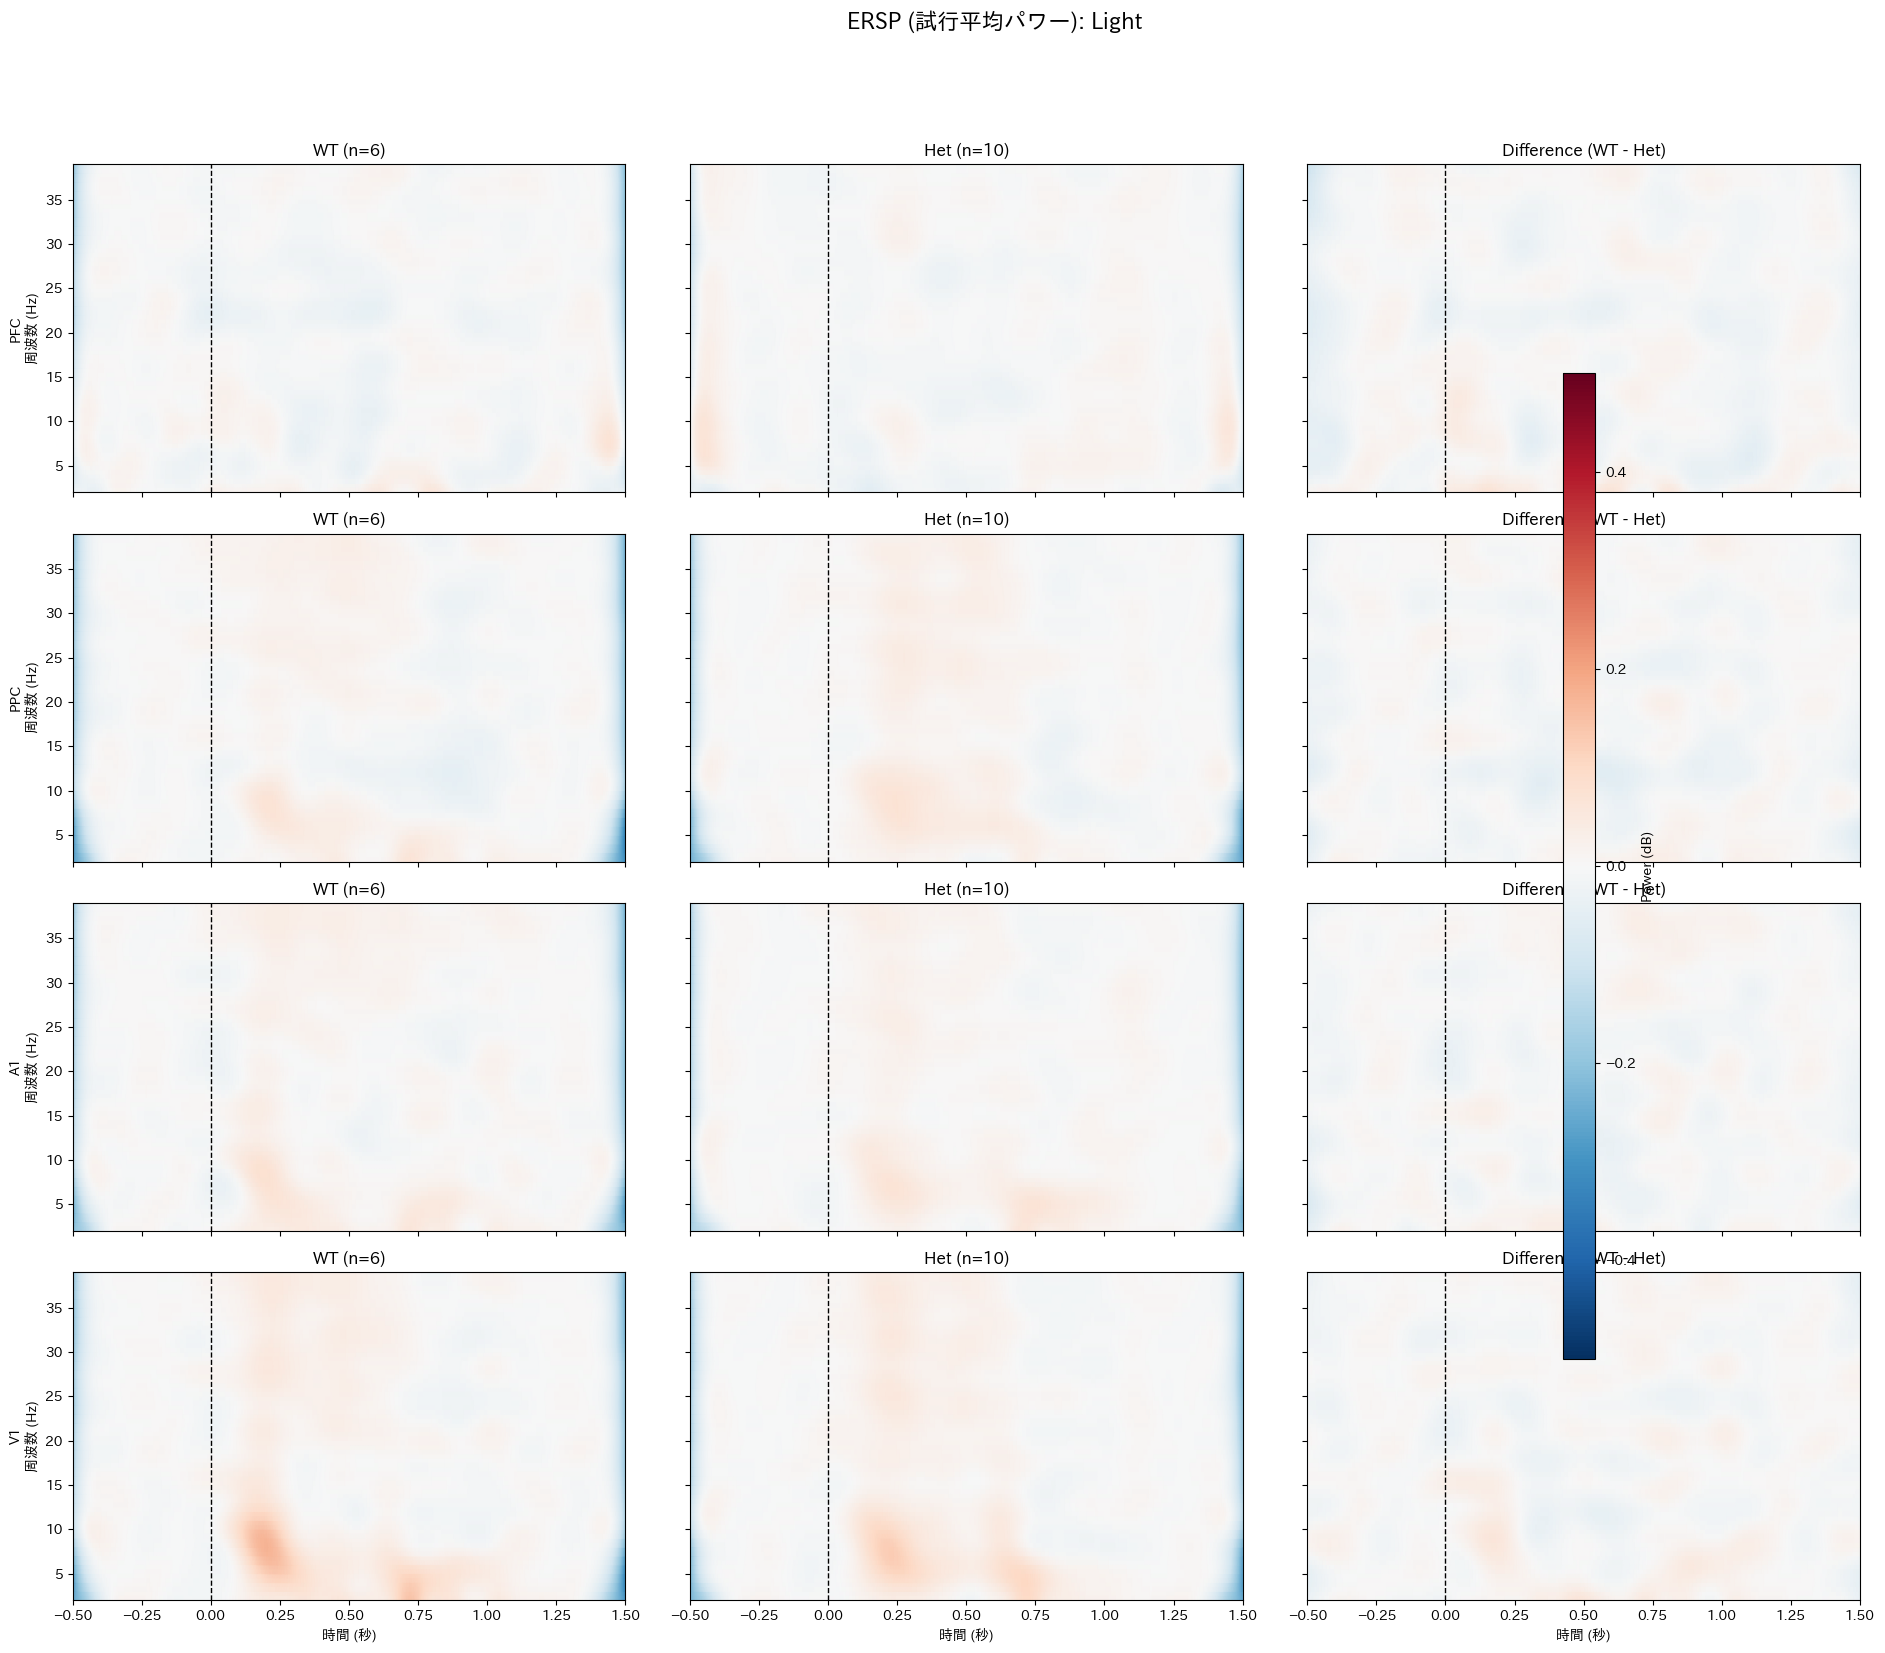

C:\Users\dmasu\AppData\Local\Temp\ipykernel_31108\1773270317.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.94, 0.98])


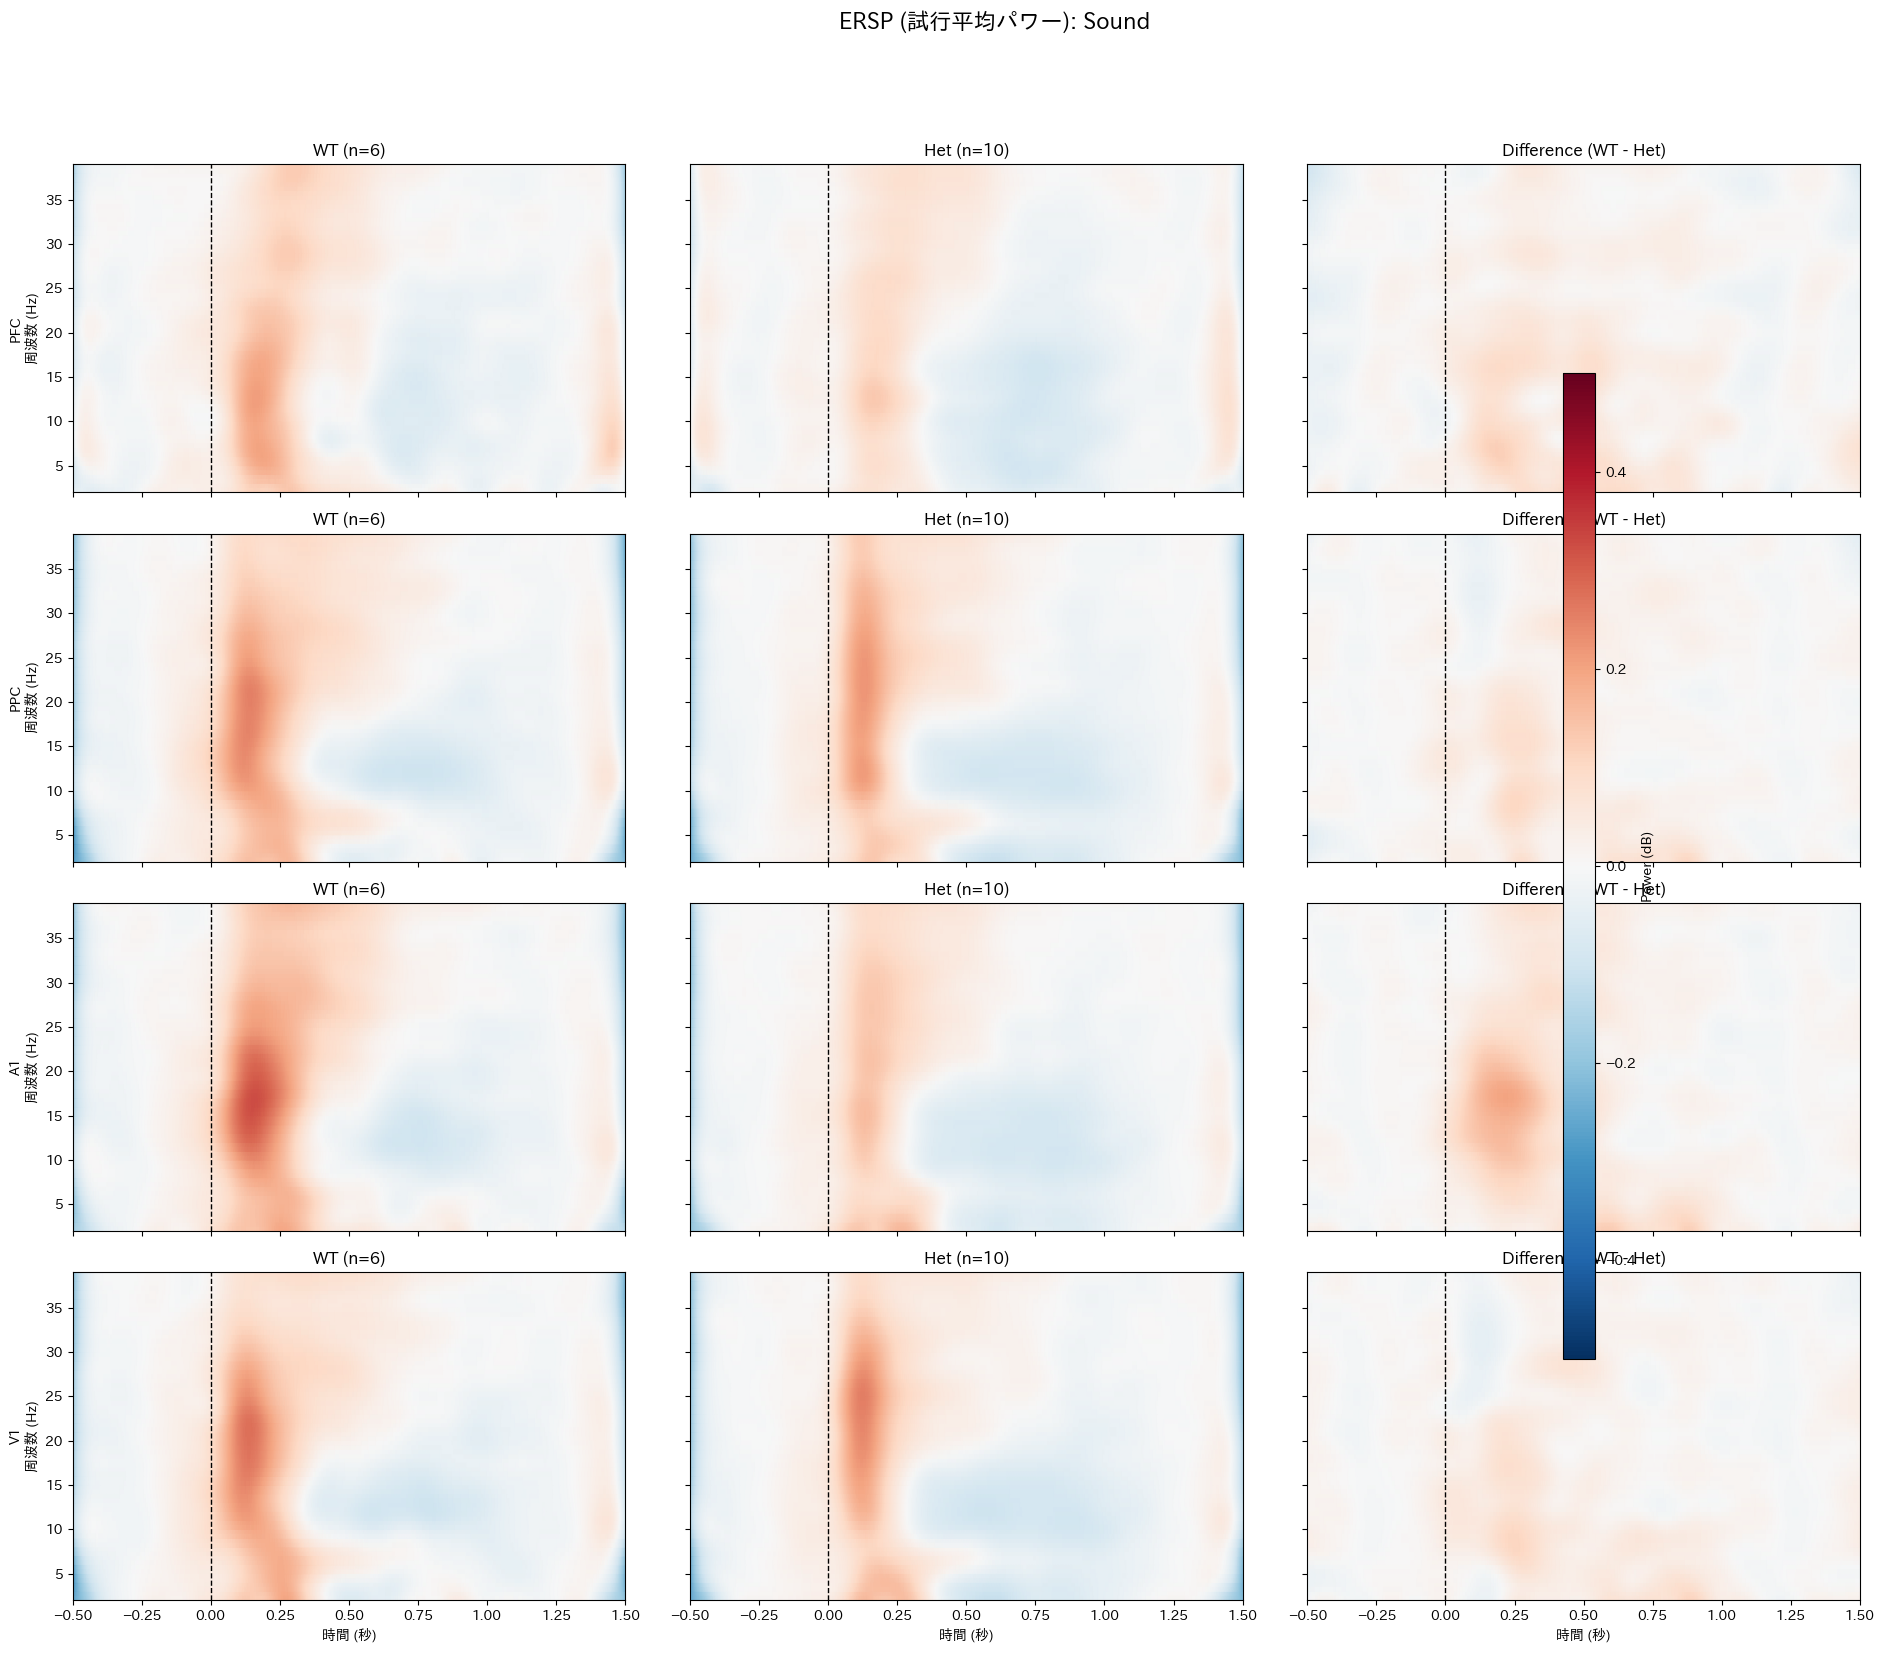

C:\Users\dmasu\AppData\Local\Temp\ipykernel_31108\1773270317.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.94, 0.98])


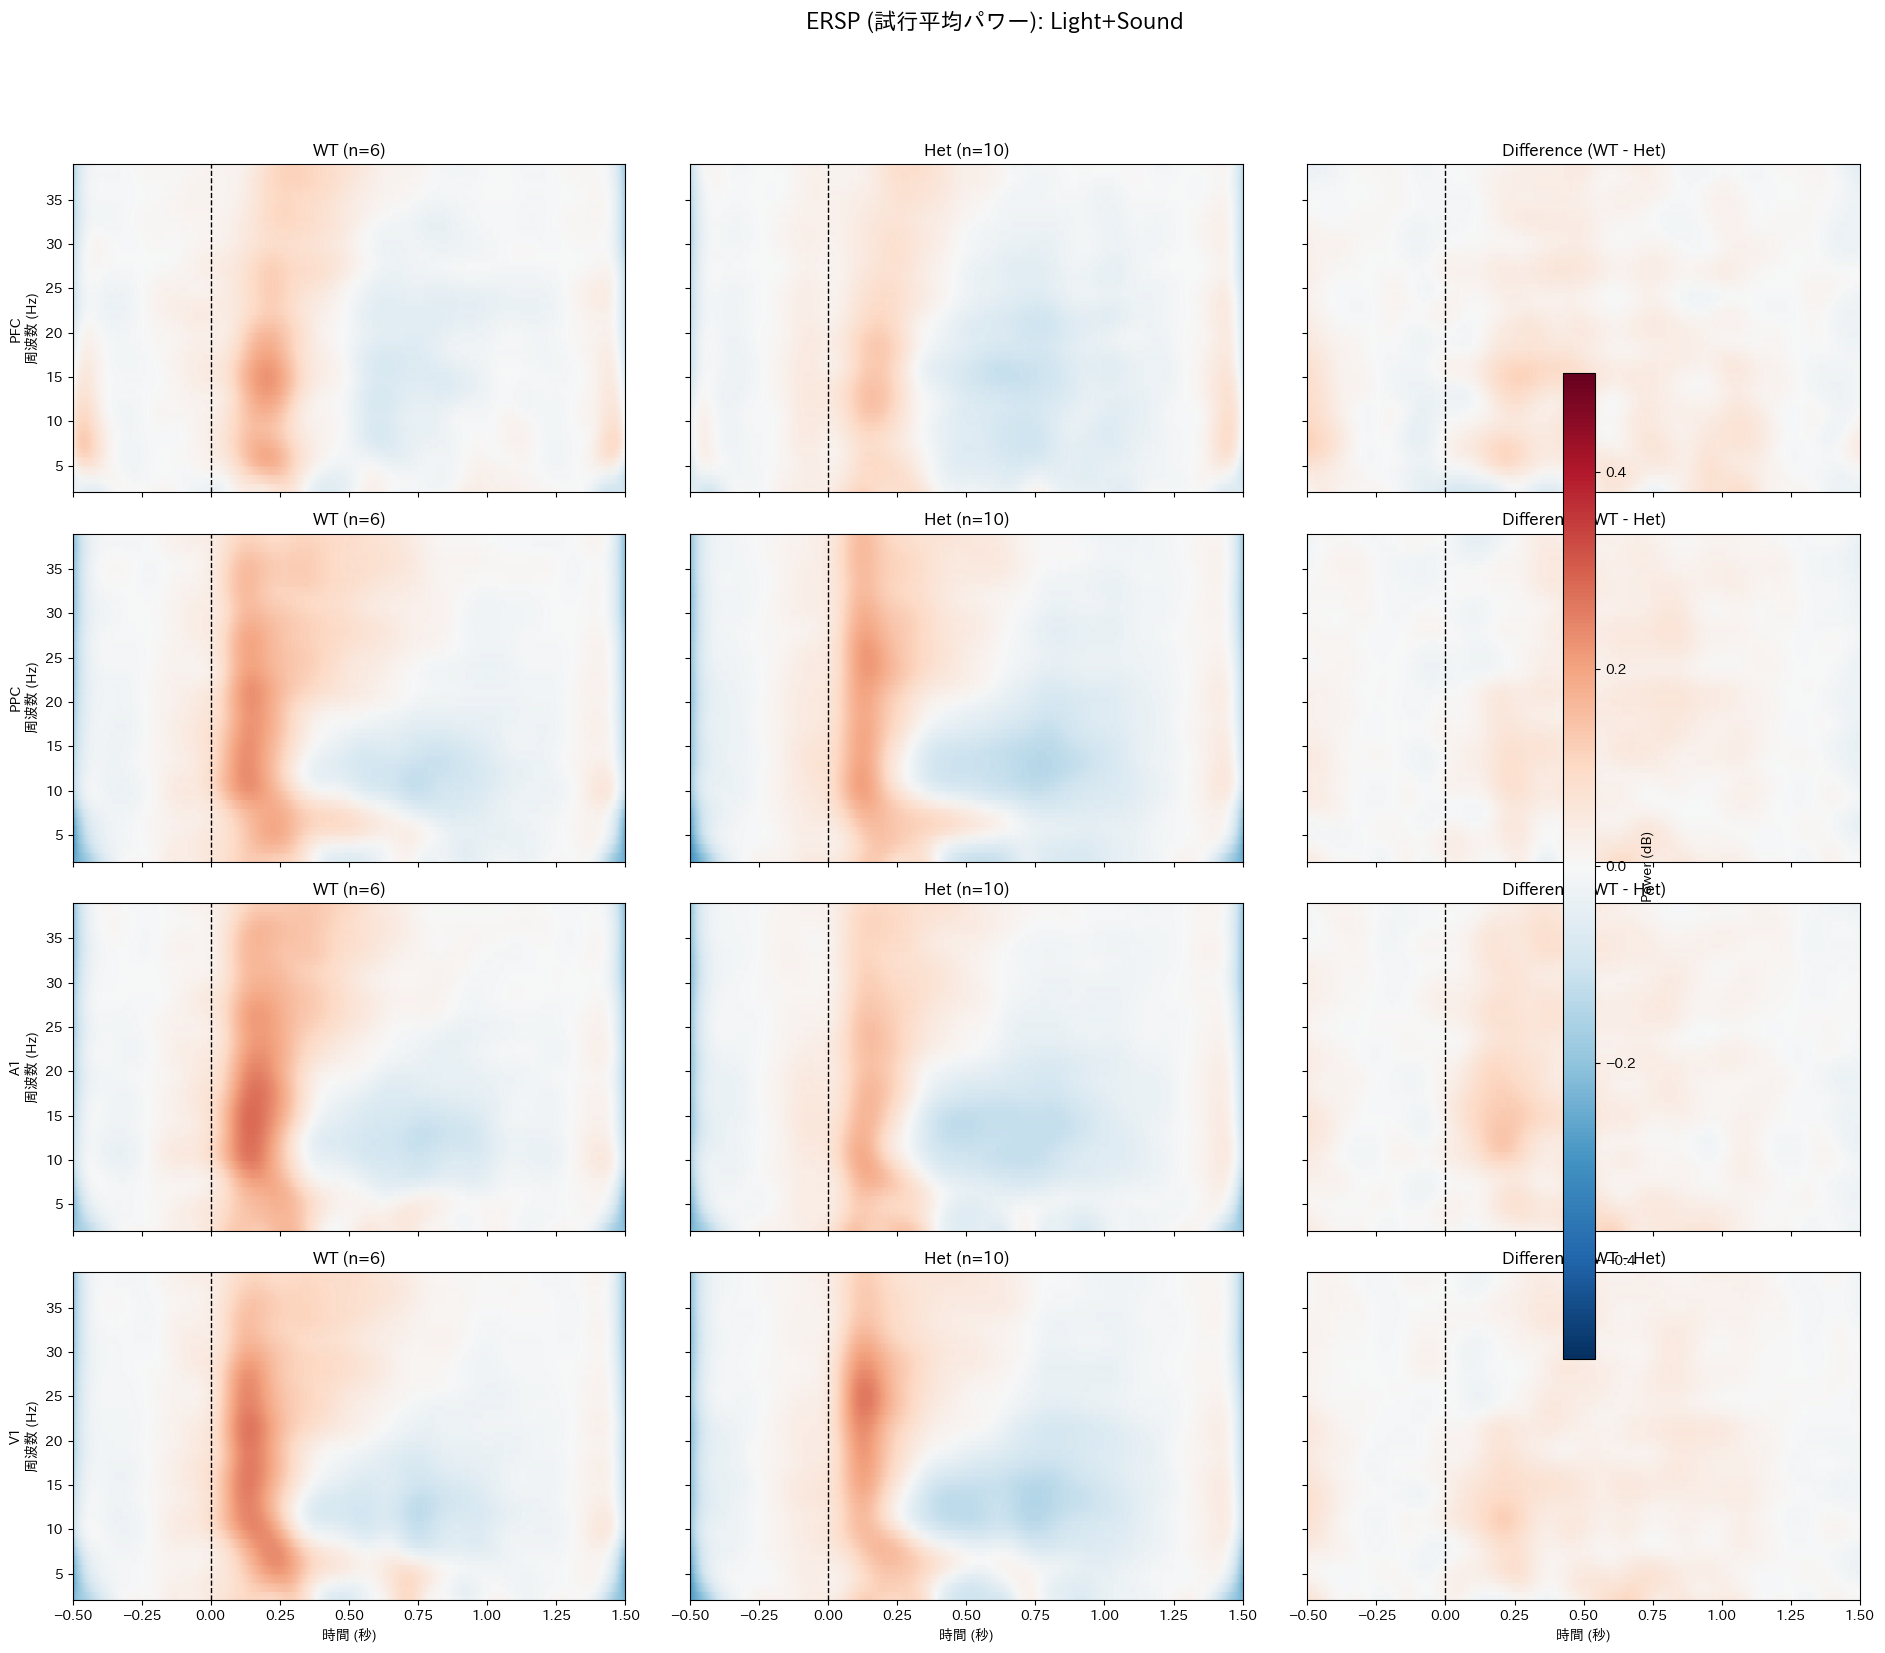

In [7]:
# --- 次回以降の実行用セル ---

# 保存したParquetデータを読み込む
ersp_dataframe = pd.read_parquet(PROCESSED_DIR / "summary_ersp_all_subjects.parquet")
print("保存済みデータを読み込みました。")

# 可視化を実行
plot_grouped_ersp(ersp_dataframe)

In [15]:
# ersp_dataframe が存在するか確認
if 'ersp_dataframe' in locals() and ersp_dataframe is not None:
    # 保存先のパスを指定 (Processed フォルダに保存する例)
    output_path = PROCESSED_DIR / "summary_ersp_all_subjects.parquet"
    
    print(f"集計データを {output_path} に保存します...")
    ersp_dataframe.to_parquet(output_path, index=False)
    print("保存が完了しました。")
    
    # （参考）次回以降の読み込み方法
    # ersp_dataframe = pd.read_parquet(output_path)
    
else:
    print("エラー: 'ersp_dataframe' がメモリ上に見つかりません。")

集計データを C:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\data\processed\summary_ersp_all_subjects.parquet に保存します...
保存が完了しました。


In [16]:
# ersp_dataframe が存在するか確認
if 'ersp_dataframe' in locals() and not ersp_dataframe.empty:
    print("--- データの基本情報 ---")
    print(ersp_dataframe.info())
    print("\n--- データの一部 (head) ---")
    print(ersp_dataframe.head())
    
    print("\n--- Genotypeのユニークな値 ---")
    print(ersp_dataframe['Genotype'].unique())
    
    print("\n--- Stimulusのユニークな値 ---")
    print(ersp_dataframe['Stimulus'].unique())
    
    print("\n--- Channelのユニークな値 ---")
    print(ersp_dataframe['Channel'].unique())
else:
    print("エラー: 'ersp_dataframe' が空か、存在しません。")

--- データの基本情報 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14599296 entries, 0 to 14599295
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Subject_ID  object 
 1   Genotype    object 
 2   Stimulus    object 
 3   Channel     object 
 4   Frequency   float64
 5   Time        float64
 6   Power_dB    float64
dtypes: float64(3), object(4)
memory usage: 779.7+ MB
None

--- データの一部 (head) ---
  Subject_ID Genotype Stimulus Channel  Frequency   Time  Power_dB
0        197      Het    Light     PFC        2.0 -0.500 -0.087024
1        197      Het    Light     PFC        2.0 -0.499 -0.085166
2        197      Het    Light     PFC        2.0 -0.498 -0.083374
3        197      Het    Light     PFC        2.0 -0.497 -0.081645
4        197      Het    Light     PFC        2.0 -0.496 -0.079977

--- Genotypeのユニークな値 ---
['Het' 'WT']

--- Stimulusのユニークな値 ---
['Light' 'Sound' 'Light+Sound']

--- Channelのユニークな値 ---
['PFC' 'PPC' 'A1' 'V1']
